## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [44]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import re
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [10]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.data.path.append("/path/to/nltk_data")

[nltk_data] Downloading package punkt to /Users/t895976/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/t895976/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df = pd.read_csv("/Users/Desktop/LHL/mini_project_V/train.csv")

In [12]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [13]:
# get the number of rows and columns in the dataset
num_rows, num_cols = df.shape
print(f'The dataset has {num_rows} rows and {num_cols} columns')

The dataset has 404290 rows and 6 columns


In [14]:
# count the number of duplicate questions
num_duplicates = df['is_duplicate'].sum()
print(f'The dataset has {num_duplicates} duplicate questions')

The dataset has 149263 duplicate questions


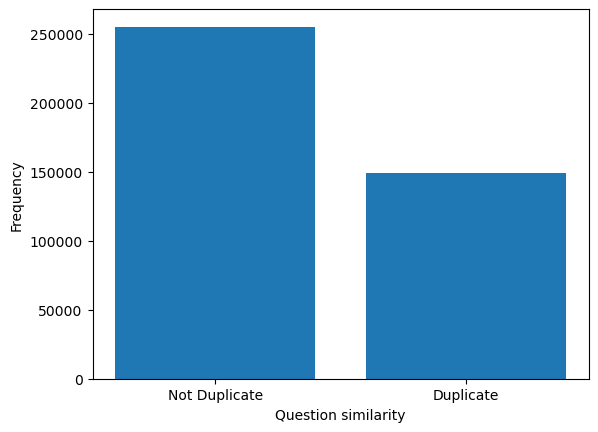

In [15]:
# plot the distribution of is_duplicate
plt.hist(df['is_duplicate'], bins=[0, 0.5, 1], align='mid', rwidth=0.8)
plt.xticks([0.25, 0.75], ['Not Duplicate', 'Duplicate'])
plt.xlabel('Question similarity')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Tokenize each question and count the number of tokens
df['question1_word_count'] = df['question1'].apply(lambda x: len(word_tokenize(str(x))))
df['question2_word_count'] = df['question2'].apply(lambda x: len(word_tokenize(str(x))))

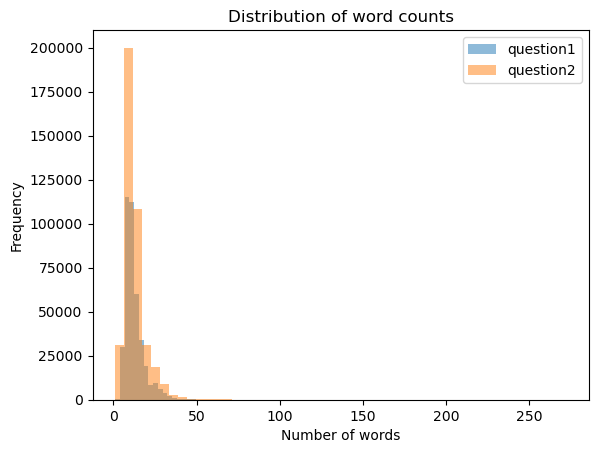

In [17]:
plt.hist(df['question1_word_count'], bins=50, alpha=0.5, label='question1')
plt.hist(df['question2_word_count'], bins=50, alpha=0.5, label='question2')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Distribution of word counts')
plt.legend(loc='upper right')
plt.show()

In [18]:
# Remove rows where either question1 or question2 is an empty string
df = df.loc[(df['question1'] != '') & (df['question2'] != '')]

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [19]:
# preprocess the text data
nltk.download('stopwords')

# create a Porter stemmer object
ps = PorterStemmer()

# create a set of English stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/t895976/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def preprocess_text(text):
    if not isinstance(text, str) or not text:
        return ''
    # convert to lowercase
    text = text.lower()
    # remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove digits
    text = text.translate(str.maketrans('', '', string.digits))
    # tokenize the text
    words = nltk.word_tokenize(text)
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # stem the words
    words = [ps.stem(word) for word in words]
    # join the words back into a string
    text = ' '.join(words)
    if not text:
        return ''
    return text

In [21]:
# Apply preprocessing on question 1
df['question1'] = df['question1'].apply(preprocess_text)

In [22]:
# Apply preprocessing on question 2
df['question2'] = df['question2'].apply(preprocess_text)

In [23]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_word_count,question2_word_count
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,15,13
1,1,3,4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,11,16
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dn,0,15,11
3,3,7,8,mental lone solv,find remaind mathmath divid,0,13,19
4,4,9,10,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,16,8


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [17]:
# tokenize the preprocessed questions
tokenized_questions = [nltk.word_tokenize(question) for question in df['question1']] + [nltk.word_tokenize(question) for question in df['question2']]

# build word2vec model on the tokenized questions
model = Word2Vec(tokenized_questions, vector_size=100, window=5, min_count=1, workers=4)

# get word vector for each word in question1 and question2
vectors1 = [model.wv[word] for word in nltk.word_tokenize(df['question1'][0])]
vectors2 = [model.wv[word] for word in nltk.word_tokenize(df['question2'][0])]

In [18]:
# add word vectors for each question to the dataframe
df['vectors1'] = df['question1'].apply(lambda x: np.array([model.wv[word] for word in nltk.word_tokenize(x)]))
df['vectors2'] = df['question2'].apply(lambda x: np.array([model.wv[word] for word in nltk.word_tokenize(x)]))

In [19]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_word_count,question2_word_count,vectors1,vectors2
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,15,13,"[[0.08894497, -0.3556128, -0.43445033, 0.33790...","[[0.08894497, -0.3556128, -0.43445033, 0.33790..."
1,1,3,4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,11,16,"[[0.8732396, 0.28945813, 0.040200427, 0.592037...","[[-0.5725357, -0.88358176, -1.3352803, 1.51429..."
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dn,0,15,11,"[[0.36014745, -0.19867449, 0.62217957, -1.4179...","[[0.8378331, -2.2851472, 0.27515545, -1.357906..."
3,3,7,8,mental lone solv,find remaind mathmath divid,0,13,19,"[[-0.013575528, -1.004543, 0.5627607, 0.712288...","[[0.2766507, 0.37506503, 2.0571866, 2.0687833,..."
4,4,9,10,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,16,8,"[[-0.28140733, 1.0078804, -0.39900336, 0.59714...","[[-1.119959, 2.088519, -0.7590938, -0.05865908..."


### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [24]:
# Separate the features and target variable
X = df[['question1', 'question2', 'question1_word_count', 'question2_word_count']]
y = df['is_duplicate']

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1, 3), norm='l2')
X_train_question1 = vectorizer.fit_transform(X_train['question1'])
X_train_question2 = vectorizer.transform(X_train['question2']) # use transform here
X_test_question1 = vectorizer.transform(X_test['question1']) # use transform here
X_test_question2 = vectorizer.transform(X_test['question2']) # use transform here

In [39]:
# Combine the vectorized data with word count features
X_train_final = hstack((X_train_question1, X_train_question2, X_train[['question1_word_count', 'question2_word_count']].values)).tocsr()
X_test_final = hstack((X_test_question1, X_test_question2, X_test[['question1_word_count', 'question2_word_count']].values)).tocsr()


In [40]:
# Train the model
model = LogisticRegression()
model.fit(X_train_final, y_train)

/Users/t895976/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
# Predict the target variable for test data
y_pred = model.predict(X_test_final)

In [42]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7446758514927404


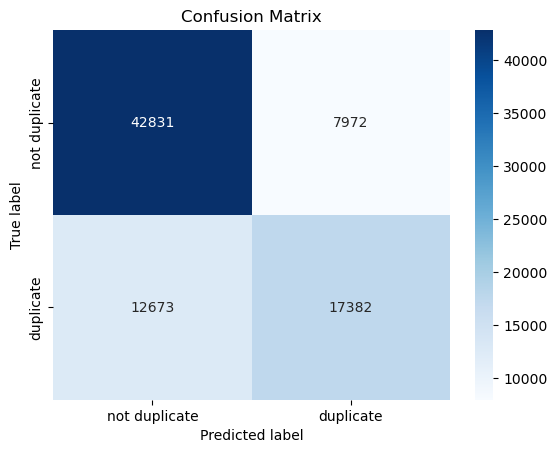

In [45]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['not duplicate', 'duplicate'], yticklabels=['not duplicate', 'duplicate'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
